Starting with rates, we can build a full working model in equilibrium and non-equilibrium conditions

In [1]:
from multibind.nonequilibrium import rate_matrix
import multibind as mb
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from equil import run # run the equilibrium model
from transport import transport # non-eq model

In [2]:
base = "diffusion"
# base = "md"

rate_files = {'diffusion' : Path('inputs') / 'diffusion_rates.csv',
              'md'        : Path('inputs') / 'md_rates.csv'}
target_dir = {'diffusion' : Path('runs') / 'diffusion',
              'md'        : Path('runs') / 'md'}

outdir = target_dir[base]

transport_magnitudes = { 'diffusion' : [-200, 220],
                         'md'        : [-200, 220],
}[base]

In [3]:
def dG2pKa(dG : float, pH : float = 0.0) -> float:
    '''Calculate the pKa from the free energy difference.
    Defaults to standard state (pH = 0).
    '''
    return pH - dG / np.log(10)

## Equilibrium conditions

We first read the rates file in and construct a friendlier graph structure. The rate files do not contain any information of ligand species and thus all of the output free energies are reported as raw Helmholtz free energies.

In [4]:
pH = 8
Na = 0.1 # 100 mM

input_rates = rate_files[base]

c, k, std = rate_matrix(input_rates)

states = c.states.values
free_energies = c.g_mle
g_std_err = c.std_errors

new_graph = c.graph.copy()

for index, data in new_graph.iterrows():
    state1, state2, value, variance, ligand, std = data
    print(state1, state2, value, variance, ligand, std)

    if (state1[-1] == "H" and state2[-1] == "0") or (state1[-1] == "A" and state2[-1] == "0"):
        # backwards proton reaction
        new_graph.at[index, 'state1'] = state2
        new_graph.at[index, 'state2'] = state1
        new_graph.at[index, 'value'] = -value
        
        value = new_graph.value[index]
        state1 = new_graph.state1[index]
        state2 = new_graph.state2[index]
        
    if state1[-1] == "0" and state2[-1] == "H":
        new_graph.at[index, 'ligand'] = "H+"
        new_graph.at[index, 'value'] = dG2pKa(new_graph.value[index], pH)
        new_graph.at[index, 'variance'] = new_graph.variance[index] / np.log(10)**2
    if state1[-1] == "0" and state2[-1] == "A":
        new_graph.at[index, 'ligand'] = "Na+"
        new_graph.at[index, 'value'] = new_graph.value[index] + np.log(Na)

print(new_graph)

IFH IF0 -3.688879454113936 0.018125 helm 1
IF0 IFNA -1.5198257537444133 0.0183966438137755 helm 1
IFNA OFNA 0.4054651081081644 0.0224444444444444 helm 1
OFNA OF0 0.6325225587435105 0.003143483726211 helm 1
OF0 OFH 3.4011973816621555 0.0156694444444444 helm 1
OFH IFH 0.4700036292457356 2.5375e-05 helm 1
  state1 state2     value  variance ligand  standard_state
0    IF0    IFH  6.397940  0.003419     H+               1
1    IF0   IFNA -3.822411  0.018397    Na+               1
2   IFNA   OFNA  0.405465  0.022444   helm               1
3    OF0   OFNA -2.935108  0.003143    Na+               1
4    OF0    OFH  6.522879  0.002955     H+               1
5    OFH    IFH  0.470004  0.000025   helm               1


Create blank model, populate it with the new graph and states. Build a scanner from this model.

In [5]:
c_equil = mb.Multibind()
c_equil.graph = new_graph
c_equil.states = c.states

scanner = mb.multibind.MultibindScanner(statefile=None, graphfile=None)
scanner.c = c_equil

Once again, we must provide some metadata since rate files do not have any of this.

In [6]:
sod_bound = {'IF0': 'unbound',
             'IFH': 'unbound',
             'IFNA': 'bound',
             'OF0': 'unbound',
             'OFH': 'unbound',
             'OFNA': 'bound',
            }

prot_bound = {'IF0': 'unbound',
              'IFH': 'bound',
              'IFNA': 'unbound',
              'OF0': 'unbound',
              'OFH': 'bound',
              'OFNA': 'unbound',
             }

conf = {'IF0': 'inward',
        'IFH': 'inward',
        'IFNA': 'inward',
        'OF0': 'outward',
        'OFH': 'outward',
        'OFNA': 'outward',
       }

scanner.c.states['conf'] = list(map(lambda x: conf[x[0]], scanner.c.states.values))
scanner.c.states['prot_bound'] = list(map(lambda x: prot_bound[x[0]], scanner.c.states.values))
scanner.c.states['sod_bound'] = list(map(lambda x: sod_bound[x[0]], scanner.c.states.values))

Run the scanner and output all the images to disk. Takes roughly 17 seconds to run.

In [7]:
run(scanner, basepath=outdir);

IFH (0.0) --> IF0 (-3.6183455479347977) => -3.6183455479347977 ± 0.10867530519285239
IF0 (-3.6183455479347977) --> IFNA (-5.0654315566327694) => -1.4470860086979718 ± 0.1269495288903638
IFNA (-5.0654315566327694) --> OFNA (-4.571937659125358) => 0.49349389750741146 ± 0.11778491397090214
OFNA (-4.571937659125358) --> OF0 (-3.927665261463871) => 0.6442723976614868 ± 0.1013600187788727
OF0 (-3.927665261463871) --> OFH (-0.4700982705359076) => 3.4575669909279636 ± 0.09557894303384766
OFH (-0.4700982705359076) --> IFH (0.0) => 0.4700982705359076 ± 0.09180907350050531
0.0


<Figure size 300x200 with 0 Axes>

<Figure size 300x200 with 0 Axes>

<Figure size 300x200 with 0 Axes>

Non equilibrium runs

['IF0/IFH', 'IF0/IFNA', 'IFNA/OFNA', 'OF0/OFNA', 'OF0/OFH', 'OFH/IFH']
   name     conf prot_bound sod_bound
0   IFH   inward      bound   unbound
1   IF0   inward    unbound   unbound
2  IFNA   inward    unbound     bound
3  OFNA  outward    unbound     bound
4   OF0  outward    unbound   unbound
5   OFH  outward      bound   unbound
  state1 state2     value  variance ligand  standard_state
0    IF0    IFH  6.397940  0.003419     H+               1
1    IF0   IFNA -3.822411  0.018397    Na+               1
2   IFNA   OFNA  0.405465  0.022444   helm               1
3    OF0   OFNA -2.935108  0.003143    Na+               1
4    OF0    OFH  6.522879  0.002955     H+               1
5    OFH    IFH  0.470004  0.000025   helm               1


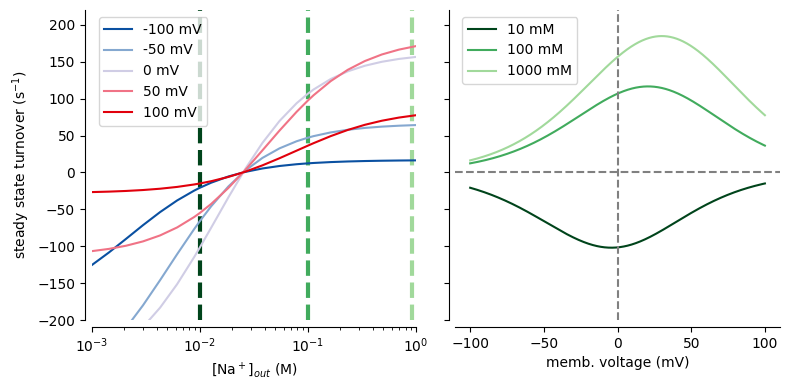

In [8]:
display_voltages = np.array([-0.1, -0.05, 0, 0.05, 0.1]) # membrane voltage range
voltages = np.concatenate([np.linspace(-0.1, 0.1, 1001)[1:-1], display_voltages]) # make a continuum with desired values
voltages.sort() # put them in order

fixed = np.array([0.001, 0.01, 0.1, 1]) # fixed sodium concentration range
na_out = np.concatenate([np.logspace(-3, 0, 20)[1:-1], fixed]) # make continuum
na_out.sort() # put in order

data = np.zeros((voltages.shape[0], na_out.shape[0])) # empty memory for results

# calculate all flux/drives for a specific point in concentration space
for i, v in enumerate(voltages):
    for j, na in enumerate(na_out):
        # rates are taken from the equilibrium case, as they must follow the same closure conditions
        # counter is used if the rates were defined at a particular concentration
        flux, drive, connection_labels, pops, Gp = transport(c_equil, k, 10**-pH, Na, **{'c_na_out': na, 'voltage': v})
        data[i, j] = flux

fig, (ax_na, ax_v) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(8, 4))

ax_na.axvline(1-0.075, linestyle='dashed', color='#a1d99b', lw=3)
ax_na.axvline(0.1, linestyle='dashed', color='#41ab5d', lw=3)
ax_na.axvline(0.01, linestyle='dashed', color='#00441b', lw=3)

ax_na.set_xlabel(r'$[$Na$^+]_{out}$ (M)')
ax_na.set_ylabel(r'steady state turnover (s$^{-1}$)')


    
na_idx001 = np.argwhere(na_out == 0.01)[0][0]
na_idx01 = np.argwhere(na_out == 0.1)[0][0]
na_idx1 = np.argwhere(na_out == 1.0)[0][0]

volt_colors =  ["#0a50a1",
                "#85a8d0",
                "#d0cde5",
                "#f07386",
                "#e1000c",]

for _i, volt in enumerate(display_voltages):
    i = np.argwhere(voltages == volt)[0][0]
    ax_na.semilogx(na_out, data[i, :], color=volt_colors[_i], label=f'{volt*1000:.0f} mV')

ax_v.plot(voltages*1e3, data[:, na_idx001], color='#00441b', label=f'10 mM')
ax_v.plot(voltages*1e3, data[:, na_idx01], color='#41ab5d', label=f'100 mM')
ax_v.plot(voltages*1e3, data[:, na_idx1], color='#a1d99b', label=f'1000 mM')

ax_v.axvline(0, color='gray', linestyle='dashed')
ax_v.axhline(0, color='gray', linestyle='dashed')

ax_v.set_xlabel("memb. voltage (mV)")

sns.despine(ax=ax_v, offset=5)
sns.despine(ax=ax_na, offset=5)

ax_na.set_xlim([0.001, 1])
ax_na.set_ylim(transport_magnitudes)

ax_na.legend(loc='best')
ax_v.legend(loc='best')

outimgdir = outdir / "img" / "noneq/"
outimgdir.mkdir(exist_ok=True, parents=True)

plt.tight_layout()
plt.savefig(outimgdir / "transport.pdf")

print(connection_labels)
print(c_equil.states)
print(c_equil.graph)